<a href="https://colab.research.google.com/github/Keenandrea/robo-trigger/blob/master/battlebot_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BattleBot: or, Machines Can Learn Too 

---



---



In [0]:
import glob
import pickle
import numpy as np
from music21 import *
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential,
                         Activation,
                         Dropout,
                         Dense, 
                         LSTM,                          
from keras.callbacks import EarlyStopping, 
                            ModelCheckpoint
from sklearn.metrics import accuracy_score, 
                            precision_score, 
                            recall_score, 
                            f1_score

In [0]:
import glob
import pickle
import numpy as np
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.utils import np_utils
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from music21 import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Mount Google Drive

---

First things first, we run a cell that will allow us to use our *Google Drive* account to store files that can be used inside the *.ipynb*. Upon execution, this cell will prompt the user to a URL where an authorization code can be copied into the notebook for access. 

In [0]:
from google.colab import drive
# prompt drive authorization
drive.mount('/content/drive')

# Import Dataset

---
The dataset consists of forty-two midi files of my own choice selection, each of which pertaining to the battle-sequence music of several different old-school console games. The games I chose from include *Chrono Trigger*, *Final Fantasy I - X*, *Sonic the Hedgehog I - III*, *Shining Force*, *Vectorman II*, and several of the *Pokemon* games.

Once these forty-two midi files were downloaded, I opened each, one-by-one, into the *MidiEditor* program. Within *MidiEditor*, I began a data-cleansing routine. My routine consisted of three major stages of editing, namely *channels*, *tracks*, and *file duration*. First, I changed every instrument channel within the midi file to Accoustic Grand Piano. Next, I removed any tracks within the file that were either percussive, echoed, or full-fledged discordance. If the midi file had any empty starting measures, I selected all events, and then shifted them to the beginning of the first measure. Furthermore, if the midi file had any empty ending measures, the file duration was trimmed down to the ending of the last eventful measure. 

## Before Editing Midi Channels

---

The following code has nothing to do with the model, only a *IPython.display* for styling for image displays.

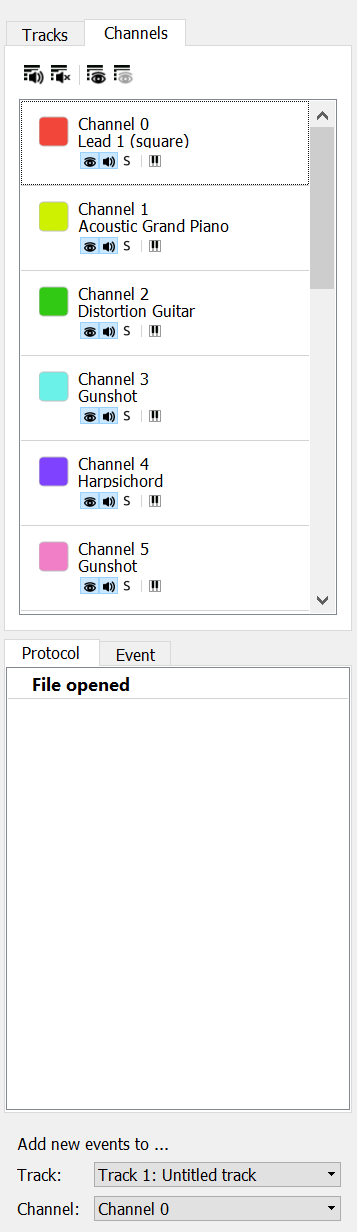

In [0]:
from IPython.display import Image
Image('midi_before_edit.PNG', width=150, height=500)

## After Editing Midi Channels

---

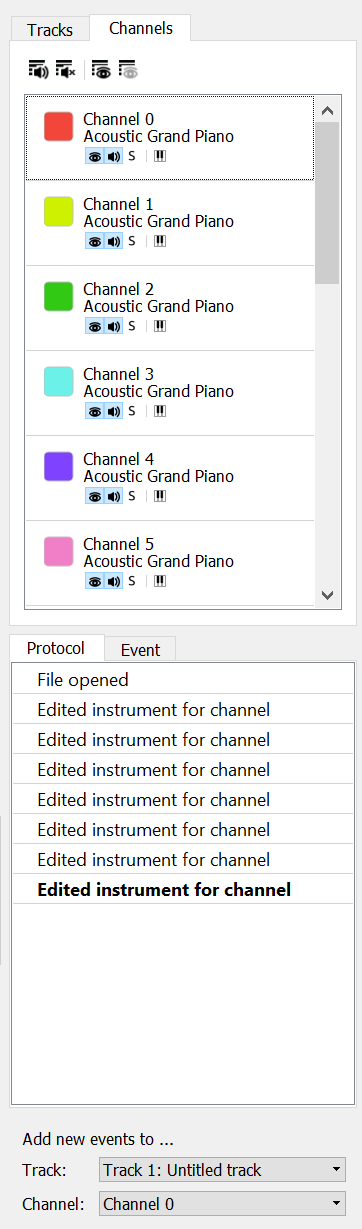

In [0]:
Image('midi_after_edit.PNG', width=150, height=500)

Finally, I noticed several of the midi files had a bassline track that would repeat the same note or two from beginning to end. This attribute was potentially harming because my preprocessing grabbed all the notes from a select few tracks. If one of those tracks happened to be the bassline, there would be an uneven amount of one or two notes in the dataset, leading the model to predict one note over and over again. So, if I came across one of these repetitive tracks, I removed it. The cleansing of my data did away with a number of outlying factors that may have had either minor or devestating affects on the performance of my model. I believe a the success of model compositions is due largely in fact to this.

In [0]:
from google.colab import files
files.upload()

In [0]:
!unzip train_dir.zip

Once the data was detoxified, so to speak, I zipped it into a neatly parceled directory, imported that directory into an *.ipynb*, then unzipped the directory for data preprocessing.

# Data Preprocessing I

---
Our preprocessing stage iterated through the training data of our midi files and returned either individual notes or chord representations in string form. MIT has a prodigious toolkit for computer-aided music theory called *music21*, which we used to both preprocess our data, and postprocess our generative sequences. We used UNIX-style *glob* functionality to grab and loop through each *.mid* file in our training directory, and parse that file by notes and chords. Once the parsing was complete, we appended the parsed notes and chords, in order, to a *notes* variable. The resulting content of *notes* was printed into an array and displayed along with the number of different notes in our dataset, which, in the training case, was 212. This number will be used further on as the number of possible output classes of our model. 

A few modifications were performed on the original code fine-tune the preprocessing. Both before and after blocks are displayed below, respectively, and the modifications employed are briefly discussed as well.

## Model I: Data Preprocessing I

---
At first, the code that preprocessed our data went as follows:



In [0]:
# def get_notes():  
  notes = []
  for i,file in enumerate(glob.glob('train_dir/*.mid')):
    midi = converter.parse(file)
    print('\r', 'Parsing file ', i, " ",file, end='')
    notes_to_parse = None
    
    try: # file has instrument parts
      s2 = instrument.partitionByInstrument(midi)
      notes_to_parse = s2.parts[0].recurse()
    except: # file has notes in a flat structure
      notes_to_parse = midi.flat.notes

    for element in notes_to_parse:
      if isinstance(element, note.Note):
        notes.append(str(element.pitch))
      elif isinstance(element, chord.Chord):
        notes.append('.'.join(str(n) for n in element.normalOrder))
  with open('notes', 'wb') as filepath:
    pickle.dump(notes, filepath)
# return notes

The figure below displays how *music21* represents music. Here we see the *Note* object, followed by the time offset.

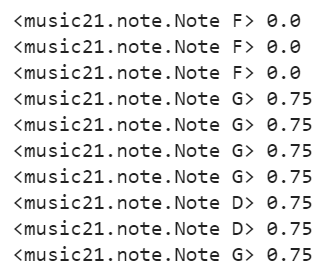

In [0]:
Image('music_object.PNG', width=250, height=200)

In [0]:
# count possible outputs
n_vocab = (len(set(notes)))
n_vocab

212

## Model II: Data Preprocessing II

---

Following our modifications, the final code used went like this:

In [0]:
notes = []
'''place the notes and chords into
   a sequential list to create the
   sequences that will be nn-input'''
for i, file in enumerate(glob.glob('train_dir/*.mid')):
    # convert supported data for
    # mats into music21 objects
    midi = converter.parse(file)
    
    # using the first 
    # five midi tracks
    midi = midi[:5]
    notes_to_parse = None
    notes_to_parse = midi.flat.notes
    print('\r', 'Parsing file ', i, " ",file, end='')
    
    '''==============================================================='''
    ''' here we will plot two graphs: a histogram for pitch class
        and a note quarter length by pitch on every midi file in 
        our dataset to further analyze what kind of data we are 
        dealing with
        =============================================================='''
#     p = graph.plot.HistogramPitchClass(midi, 
#                                    title='Pitch Class Histogram for on ' + file, 
#                                    figureSize=(10,6))
#     p.id
#     p.run()

#     v = midi.parts[0]
#     v.measures(1,20).plot(title='Note Quarter Length by Pitch on ' + file)
    '''==============================================================='''
        
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))
                
print("\n\rFinished parse")    
# Get all pitch names
pitches = sorted(set(item for item in notes))
vocab_length = len(pitches)  
number_notes = len(notes)
print(vocab_length)
print(notes)

For further representation of the data, a *music21* histogram for pitch class and another for note quarter length of the first twenty measures of two songs are displayed below:

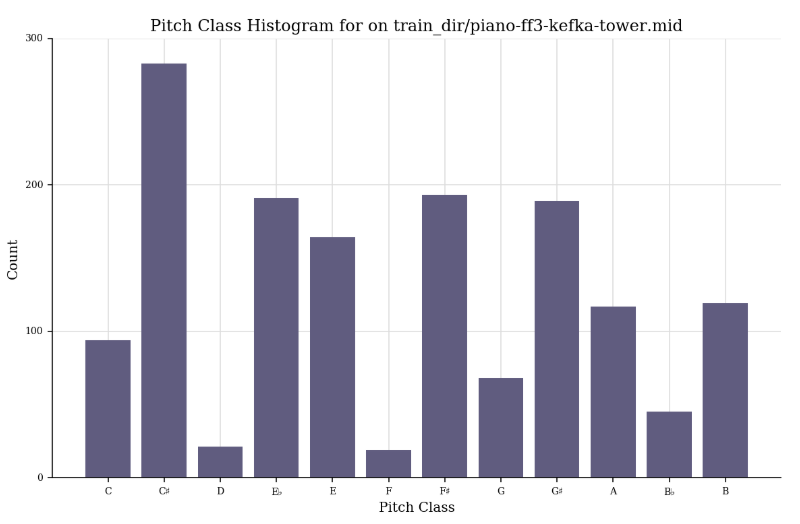

In [0]:
Image('histogram_kefka.PNG', width=450, height=350)

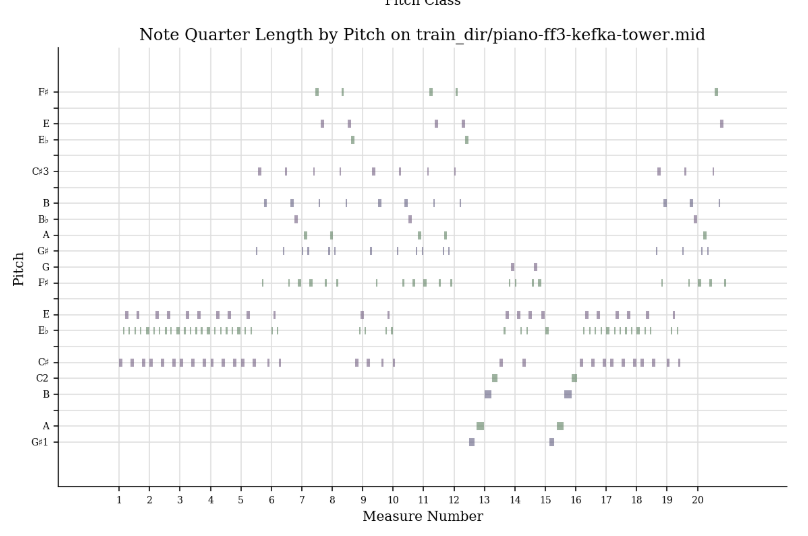

In [0]:
Image('note_quarter_kefka.PNG', width=475, height=350)

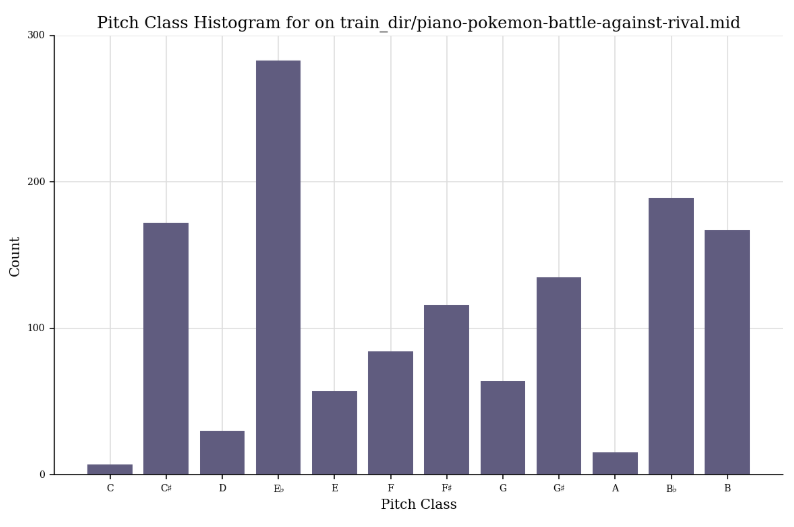

In [0]:
Image('histogram_pokemon.PNG', width=450, height=350)

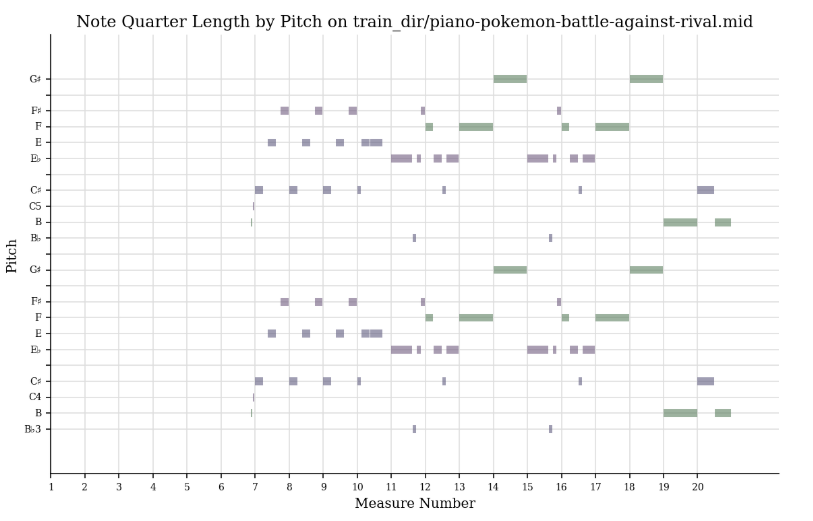

In [0]:
Image('note_length_pokemon.PNG', width=450, height=350)

## What Changed Between Models I & II?

---

Not much an a whole lot. For starters, the original code grabbed every track from the midi file and parsed it down. Upon further investigation into my midi tracks and their corresponding events, we noticed track 0 through track 5 held the meat and potatoes of the music, that is, the melody, the bass, the chords, and so on, whereas track 6 through to the rest consisted of fillers and noise and events that were not necessarily pivotal to the success of the model. So we placed a range on the tracks: from then on our preprocessing grabbed notes and chords from track 0 through track 5, and abandoned the rest.

How did this play? Well, seemingly profound. Before this little modification, the generated music sounded stochastic, arbitrary, and without rythm nor structure. After the modification the generated music began to conform to a pattern, and, in other words, began to sound more like, well, music.

Other minor modifications were made to this block, as with a quick brushing comparison between to two cells listed above, you will be able to recognize. But none of these had such a profound impact on the generative model as the track limit, so we will leave them out of discussion. 

# Data Preprocessing II

---
The second block of preprocessing code formats the obtained notes into a applicable form for our *LSTM*. Sequences abled to be grouped together to predict the next note are constructed by *one-hot encoding* each of the notes, and then creating an array of sequences. 

First, an index is assigned to each possible note of 212, as mentioned earlier. Out of that, sequences are constructed by taking each note and encoding it into a numpy array with a '1' in the position of the note given. In this particular block, there is one variable that has a determining sway over the generative output of our model. That variable is *sequence_length*. The length of a sequence is how our network makes its prediction of the next note or chord. Our network bases the next sequence output on the previous sequence input, a sort of snake-eating-its-own-tail process that helps the model locate pattern and rythm in its work. Based on our training analytics, I found that the most fitting length for sequences with my provided data was 50. However, that number is not magic. It can be tuned to better suit other datasets and models, and is one of the pivots in successfull generative sequencing.  

A few modifications were performed on the original code fine-tune the preprocessing. Both before and after blocks are displayed below, respectively, and the modifications employed are briefly discussed as well.

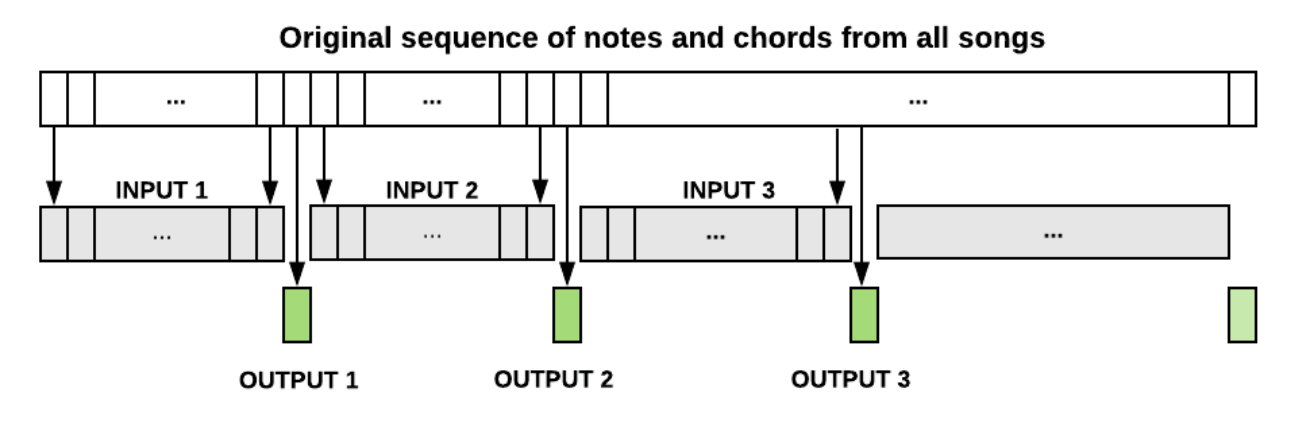

In [0]:
Image('sequence_modeling.PNG', width=550, height=200)

## Model I: Data Preprocessing II

---

Another block of preprocessing code was modified from its original content to aid the model. Here is the original:

In [0]:
# def prep_sequences(notes, n_vocab):
  sequence_length = 100
  # collect all of the pitch names in MIDI data
  pitchnames = sorted(set(item for item in notes))
  # create a dictionary that maps pitches to integers
  note_to_int = dict((note, number) for number, note in 
                      enumerate(pitchnames))
  # original dataset
  base_input = []
  base_output = []
  # training dataset
  network_input = []
  network_output = []
  #validation dataset
  val_input = []
  val_output = []

  # create input sequences and corresponding outputs
  for i in range(0, len(notes) - sequence_length, 1):
    # to predict the next note in the sequence
    # the network has the previous sequence_le
    # ngth notes to acclimatize its prediction
    sequence_in = notes[i:i + sequence_length] 
    sequence_out = notes[i + sequence_length] 
    # map pitches of sequence_in to integers
    base_input.append([note_to_int[char] for char in sequence_in])
    # map integer of sequence_out to an integer
    base_output.append(note_to_int[sequence_out])    
 
  n_patterns = len(base_input)

  # reshape the input into a format compatible with LSTM layers
  base_input = np.reshape(base_input, (n_patterns, sequence_length, 1))
  # perform normalization on the input
  base_input = base_input / float(n_vocab)
  # categorical, or, one-hot encoding the output
  base_output = np_utils.to_categorical(base_output)
  
#   return (network_input, network_output)

In [0]:
print('original network_input shape')
print(base_input.shape)
print('\noriginal network_output shape')
print(base_output.shape)

# training set, split with first 80% of base
network_input = base_input[:35873,0:100,:1]
network_output = base_output[:35873,:212]

# validation set, split with last 20% of base
val_input = base_input[35873:,0:100,:1]
val_output = base_output[35873:,:212]

print('\nnetwork_input shape after split')
print(network_input.shape)
print('\nnetwork output shape after split')
print(network_output.shape)

print('\nvalidation input shape')
print(val_input.shape)
print('\nvalidation output shape')
print(val_output.shape)

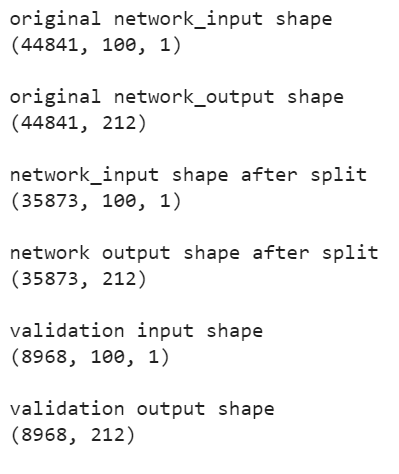

In [0]:
Image('split.PNG', width=250, height=300)

## Model II: Data Preprocessing II

---

And here is the modified version we used to preprocess data for our model:

In [0]:
# assign an index to 
# each possible note
note_dict = dict()
for i, note in enumerate(pitches):
    note_dict[note] = i

# construct sequences 
# by taking each note 
# and encoding it int 
# o a numpy array wit
# h a '1' in the posi
# tion of the note th
# e sequence has
sequence_length = 100
# make a numpy array with the number of train
# ing examples, sequence length, and the leng
# th of the one-hot-encoding
num_training = number_notes - sequence_length

input_notes = np.zeros((num_training, sequence_length, vocab_length))
output_notes = np.zeros((num_training, vocab_length))

# i is the training example, j 
# is the sequence note for the 
# specific training example
for i in range(0, num_training):
    input_sequence = notes[i: i+sequence_length]
    output_note = notes[i+sequence_length]
    for j, note in enumerate(input_sequence):
        input_notes[i][j][note_dict[note]] = 1
    output_notes[i][note_dict[output_note]] = 1

## What Changed Between Models I & II?

---

Once again, not much. And, this time, not much. One-hot encoding of the sequences was performed differently. Instead of normalizing the input sequence, and then one-hot encoding the output sequence, we decided to one-hot encode the input and output sequences both. This allowed the representation of our data more expressivity. It offers the machine numbered data instead of character data with which to train, which is important when inputting into an *LSTM*. In so doing, we have made the prediction problem a deal easier for our model to solve.

# Model Architecture

---

Our model architecture employs four layer types.


1.   **LSTM:** or, long-short-term memory layer, is an *RNN* layer that takes a sequence as an input, and then returns either sequences, or a matrix.
2.   **Dropout:** a regularization technique consisting of setting a fraction of input units to 0 at each update during training to fight overfitting. The parameter applied to this layer determines the fraction amount.  
3.   **Dense:** or, fully connected neural network layer in which each input node is connected to each output node.
4.   **Activation:** employed to determine the activation function our neural network will use to calculate the output of a node.

For the first LSTM layer, we provide a unique parameter *input_shape* to inform the network of the shape of the training data.

## Loss Function

---

Calculations of loss for each iteration of the training use *categorical_crossentropy* since each output belongs only to a single class, and since we have greater than two classes to work on.

## Optimizer

---

Our network is optimized by *rmsprop*, which normally fits best on *RNNs*, and as *RNNs* are derivative of *LSTMs*, it made sense to employ.

Later in the analysis we cover training under two additional optimizers, *sgd* and *Adam*, and discuss the results.

We also experimented, though briefly, into declaring our own optimizer, using *keras* to adjust the learning rate of *rmsprop*.



In [0]:
# modified rmsprop optimizer with an
# adjustable learning rate for train 
RMSprop = optimizers.rmsprop(lr=0.01)

## Model I: Architecture
---



In [0]:
def create_network(network_input, n_vocab):
  model = Sequential()
  model.add(LSTM(256, 
               input_shape=(network_input.shape[1], network_input.shape[2]),
               return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(512, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(256))
  model.add(Dense(256))
  model.add(Dropout(0.2))
  model.add(Dense(n_vocab))
  model.add(Activation('softmax'))
  model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics = ['accuracy'])
  return model

In [0]:
model = create_network(base_input, n_vocab)

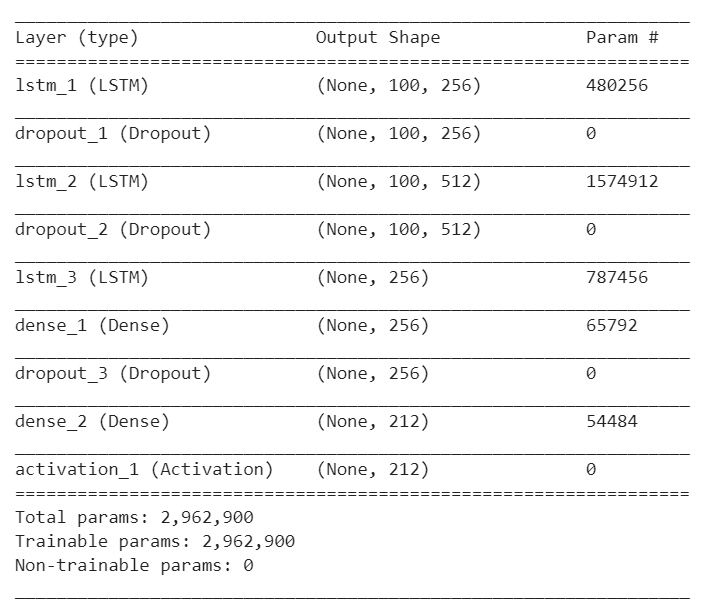

In [0]:
Image('upgraded_model_summary.PNG', width=650, height=600)

## Model II: Architecture

---



In [0]:
model = Sequential()
model.add(LSTM(512, return_sequences=True, 
               input_shape=(sequence_length, vocab_length)))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(Dense(vocab_length))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics = ['accuracy'])

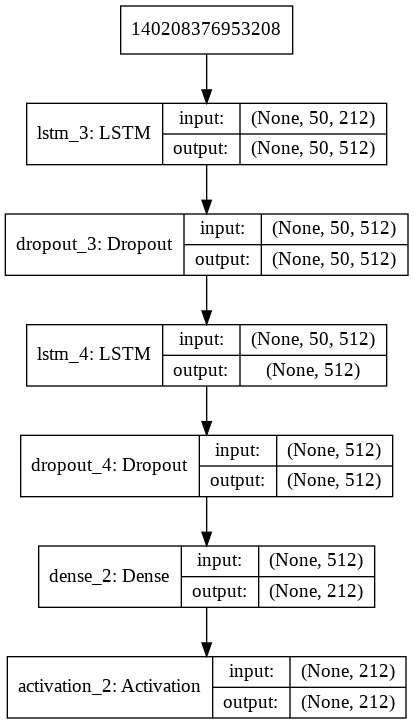

In [0]:
Image('this_model.png', width=250, height=400)

## What Changed Between Models I & II?

---


The original architecture kept shape, more or less. Although we didn't pipeline our dataset through a varied assortment of generative models, such as *GRU*s, *VAE*s, or *Encoder-Decoder*s, we did tinker a tidbit. First tinker performed was the adjustment, or, the removal of three layers, namely:

**model.add(LSTM(512))**

**model.add(Dense(256))**

**model.add(Dropout(0.3))**

These three layers were inset, one after the other, following the second *Dropout* layer, and preceding the first *Dense* activation. Apart from the removal of these layers, both *Dropout* functionalities were originally 0.3, and, after some training, sized down to 0.2. Then, after further training, sized back up to 0.3.

Later on, we returned the removed *LSTM*, *Dense*, and *Dropout* layers to their original positions within the architecture. In addition, we bumped the first and second *LSTM*s down from 512 to 256. 

This express modification can be thought of as a lessening to the dimensionality of the output space of the *LSTM*, or, in layman's terms: the number will contain multiple parallel *LSTM* units, structurally identical, but each eventually learning to remember some different thing.


In [0]:
model.summary()

# Training

---
We perform a train to validate split using *keras.model.fit*'s *validation_split* parameter instantiated  with a 0.2 cut, or 80% to 20% data split between train and validate, in that order. 

Implemented on top of the training and validation, our model performs a save following the completion of every epoch using *tf.keras.callbacks.ModelCheckpoint*, which saves the model checkpoints with the epoch number and the validation loss into our Google Drive account. The model checkpoints are the weights of the model. These weights can be employed to perform predictions as is, or used as the basis for ongoing training.

The only remolding from our original model in the *train_network* function worked on the *batch_size* parameter, which was originally set to 64, and resized to 128, then amended again to 64, and yo-yoed between those two values throughout.

## Model I: Training

---


In [0]:
# def train(model, network_input, network_output):
  filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
  
  checkpoint = ModelCheckpoint(filepath, monitor='loss', 
                               verbose=1, save_best_only=True, mode='min')
  callbacks_list = [checkpoint]

  history = model.fit(network_input, network_output, batch_size=128, epochs=20, 
                      validation_data(val_input, val_output), 
                      callbacks=callbacks_list)

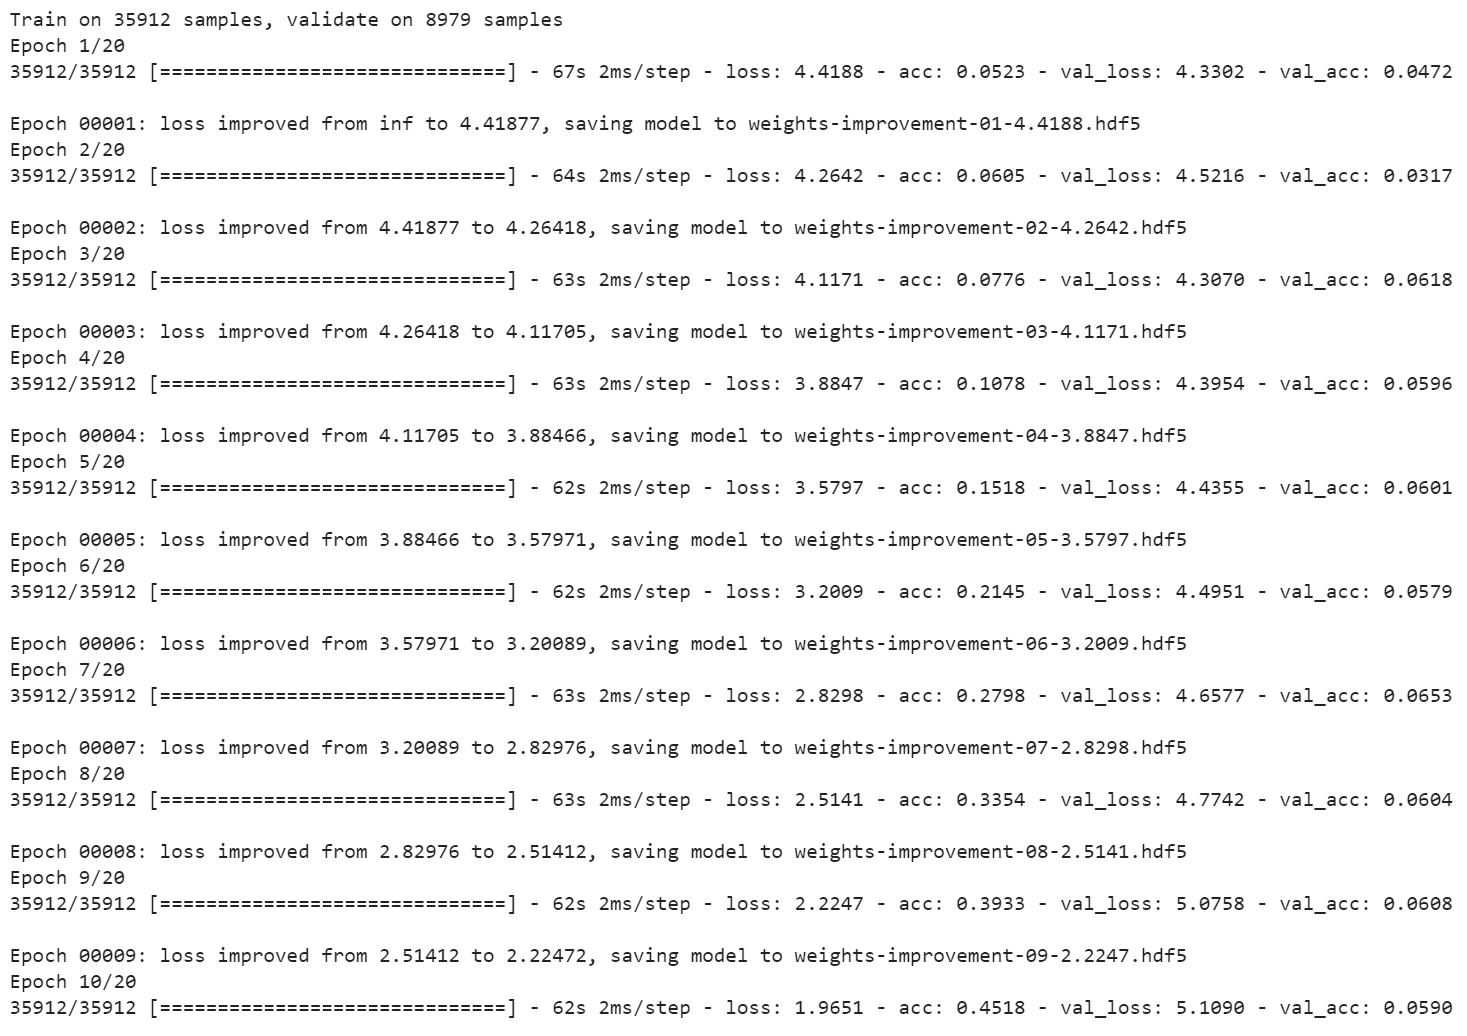

In [0]:
Image('train_with_weightage.PNG', width=925, height=700)

## Model II: Training

---


In [0]:
# def train(model, network_input, network_output):
  filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
  
  checkpoint = ModelCheckpoint(filepath, monitor='loss', 
                               verbose=1, save_best_only=True, mode='min')
  callbacks_list = [checkpoint]

  history = model.fit(input_notes, output_notes, batch_size=64, epochs=20, 
                      validation_split=0.2, callbacks=callbacks_list)

# Metrics

---

The following cell uses *matplotlib.pyplot* to plot the learning curves on the training and validation subsets of our dataset. 

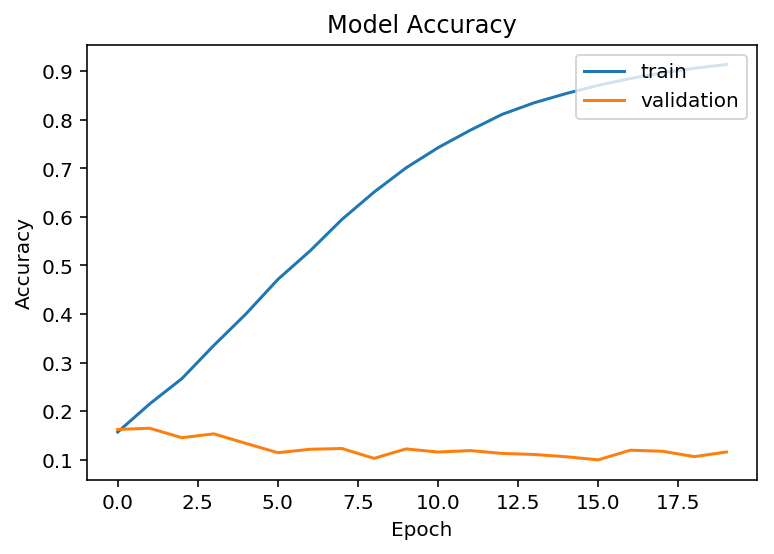

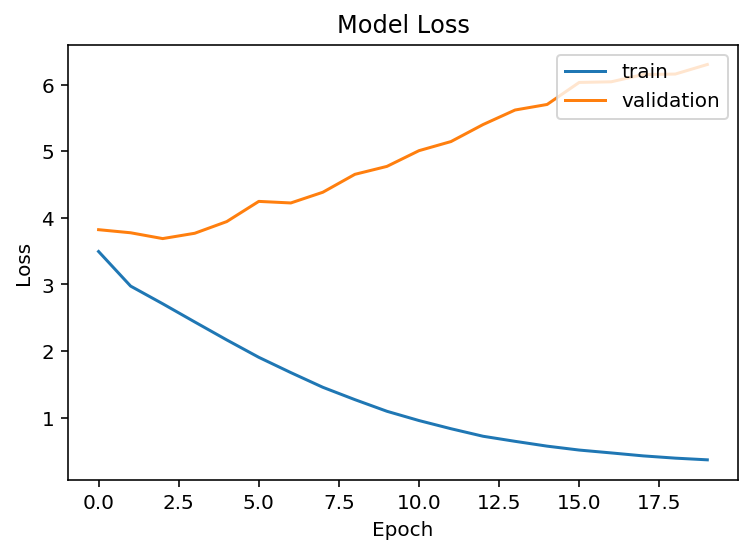

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], 
           loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], 
           loc='upper right')
plt.show()

Interpreting this particular instance of our model, we find that the loss and accuracy for both training and validation tend to split near the first several epochs, and then continue in their own similar fashion. 

Regarding *accuracy*, the curve displayed for each function has an orderly cut, signifying the model learns like a bat out of hell from the starting-gate, and continues to learn as the epochs grow, easing the pace at which it does so into a markedly relaxed rate around approximately 15 training epochs, and 10 validation epochs. 

Most noticably, the recurring characteristic shows a high training accuracy and a low validation accuracy. The contrast here creates a gap symptomatic of overfitting. 

The *loss* metric, in comparison, doesn't exactly achieve the desired curves either. The training loss commits to decreasing, which is just dandy; however, the validation loss produces an increase, which is undesirable.

Furthermore, we are, yet again, seeing a gap, or a divergence between the training and validation loss functions. These metrics clearly amount to overfitting of our model. 

---

So then, how do we fight against overfitting? There are a few adjustments we can make use of:

1.   Slim the dataset *
2.   Lessen the learning-rate *
3.   Increase the dimension of the input representation space *

---



1) 

To slim the dataset I reduced the number of midi files from 42 down to 8. This gave us a decrese from 212 down to 92 different notes in our dataset. The *sequence_length* parameter was set to 100. The model trained on 4147 samples, validated on 1037 samples. Here are the metric results: 

---




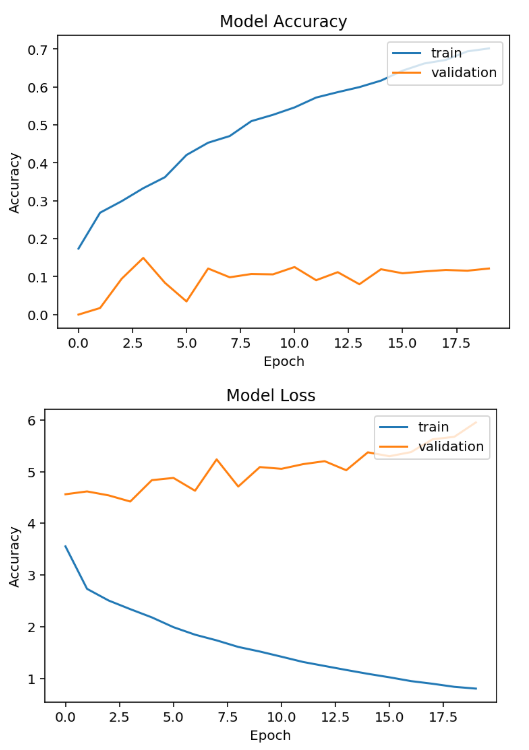

In [0]:
Image('after_slimming_dataset_epochs_20_sequences_100.PNG', width=350, height=500)

2) a) 

Lessening the learning-rate consisted of creating a new variable, or optimizer:

*RMSprop = optimizers.rmsprop(lr=0.01)*

This is the declaration of a new optimizer with a new learning-rate argument passed into it as a parameter. The default learning-rate for *rmsprop* is 0.1, therefore, our new learning rate has lessened by 1/10 to 0.01. Here are the metric results:

---



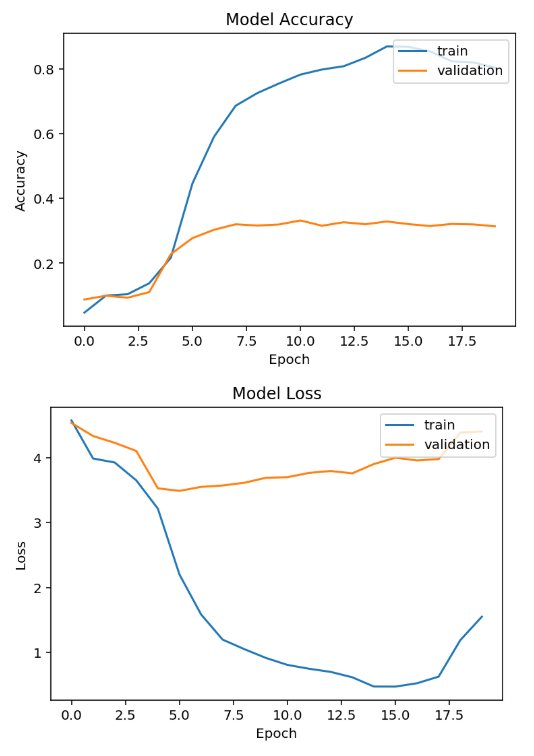

In [0]:
Image('analytics_epochs_20_sequences_50_lr_0dot01.PNG', width=350, height=500)

2) b) 

The results are better, however, they aren't splendid enough. So, I've decided to lessen the learning-rate even further. If the default learning-rate for *rmsprop* is 0.1, and the previously lessened learning-rate was 0.01, I've decided, as a last-ditch effort, to reduce the learning-rate to 1/100 of it's default, that is: 0.001. Below are the resulting metrics:

---



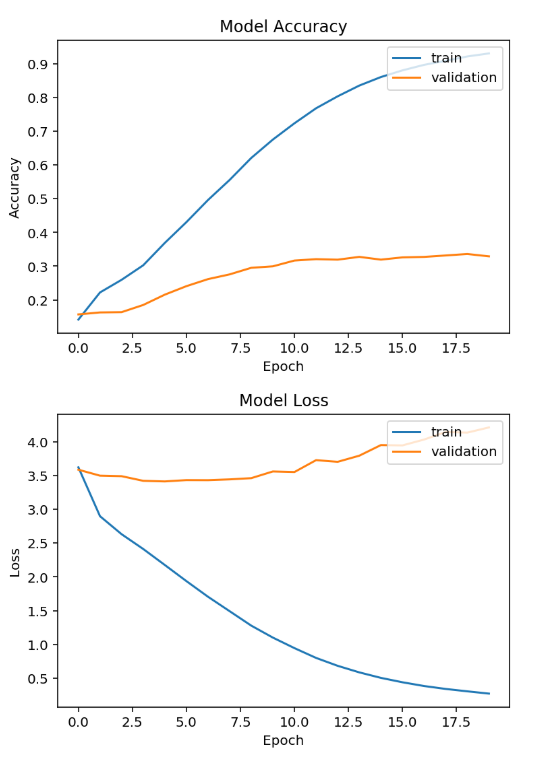

In [0]:
Image('analytics_epochs_20_sequences_50_lr_0dot001.PNG', width=350, height=500)

3) 

The dimension of the input representation space is defined:

*input_shape=(sequence_length, vocab_length)*

The purpose of this parameter is to inform the network of the shape of the data it will be training. Ours is 50, 212. The *vocab_length* of 212 is a number I'll keep static, since it is the number of unique notes in my dataset. Although I noticed *sequence_length = 50* generated the most interesting music, I had previously trained the network on (at the lower end) 25 sequences and (at the greater end) 100 sequences, and the loss and accuracy metrics displayed overfitting.

So we'll employ this suggestion, we'll amp up the *sequence_length* to 100 from here on out and call it.

---


Also, by further investigation, other methods of can be put through their paces to defeat model overfitting, for instance:

4.   Try a new optimizer *

---



4) 

There are two viable optimizers for my model, apart from *rmsprop*: *Adam* and *sgd*.

I'd formerly used *Adam* as the optimizer to another *seq2seq* prediction model of mine. The results during production of that model were less than satisfying. 

So I've decided to leave out any training with *Adam*, and focus on the *sgd* optimizer. 

The train and validation curves for both loss and accuracy functions removed the aforementioned *gap* that was pestering the results. However, during testing, the music generated on the *sgd* optimizer was absolute garbage, outputting one note over and over and over and over again, and so on. Here are the metrics under *sgd*:

---



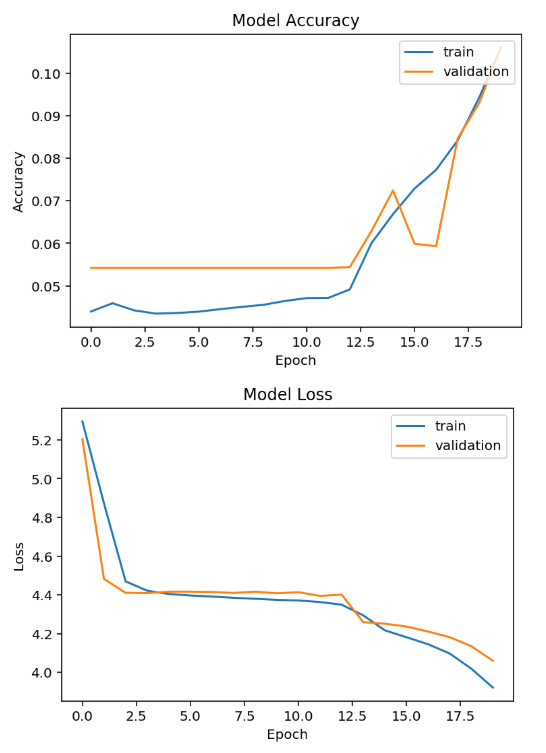

In [0]:
Image('analytics_20_epochs_100_sequences_lr_0dot01_optimizer_sgd.PNG', width=350, height=500)

But every cloud has a silver lining, as the saying goes. 

Considering the poor execution of my model under the *sgd* optimizer, and the abysmal performance of my former model, mentioned in the last paragraph, under the *Adam* optimizer, I've gained insight on which optimizer is tailored to our model, that is: *rmsprop*.

Furthermore, taking into account the desirable gap between training and validation metrics under *sgd* in connection with the widely produced gap between training and validation metrics under *rmsprop*, and moreover hearing the generative results after testing on each, I've considered a hypothesis: 

Perhaps, insofar as my generative model is concerned, overfitting is healthy.

To either prove or disprove this hypothesis, I will begin to rework the architecture, on the off chance that I can produce musical generatives, finer curved metrics, or, with all hope beside me, both.

## Reformed Architecture

---
Before anything else, I rewrote the validation set. Where *validation_split=0.2* was used, now *validation_data* with parameters *(val_input, val_output)* resides, alongside its training set counterpart, declared as *network_input* and *network_output*.

The original dataset, made of parts *base_input* and *base_output*, was acted upon with a 80-20 split. The training set aquired the first 80%, while the validation set aquired the last 20%.

What's more, ten midi files, incorporating roughly 10% of our original dataset, were cut from production. The decision was arbitrary. The ten files unfastened and erased from the dataset were battle theme midi files I had cleansed from the *Pokemon* video games. Although this wasn't necessarily a step that needed to be taken, personally, I think the *Pokemon* files were too noisy and uncoordinated with the rest of the dataset.

As for the architecture itself, in a nutshell, I advanced from:

      model = Sequential()
      model.add(LSTM(256, 
                   input_shape=(base_input.shape[1],     
                   base_input.shape[2]),
                   return_sequences=True))
      model.add(Dropout(0.2))
      model.add(LSTM(512, return_sequences=True))
      model.add(Dropout(0.2))
      model.add(Dense(n_vocab))
      model.add(Activation('softmax'))
      model.compile(loss='categorical_crossentropy', 
                    optimizer='rmsprop', 
                    metrics = ['accuracy'])
                    
 to:
 
      model = Sequential()
      model.add(LSTM(256, 
                   input_shape=(base_input.shape[1], 
                   base_input.shape[2]),
                   return_sequences=True))
      model.add(Dropout(0.3))
      model.add(LSTM(512, return_sequences=True))
      model.add(Dropout(0.3))
      model.add(LSTM(256))
      model.add(Dense(256))
      model.add(Dropout(0.3))
      model.add(Dense(n_vocab))
      model.add(Activation('softmax'))
      model.compile(loss='categorical_crossentropy', 
                    optimizer='rmsprop', 
                    metrics = ['accuracy'])
                    
 Or, in other words, I added an *LSTM*, a *Dropout*, and a *Dense*, stacked in that order, near the center of the model, and then increased the *Dropout* at every instance from 0.2 up to 0.3. Let's call it a souped-up version of the previous architecture. 
 
 Before the architecture never spent greater than two minutes to run an epoch, more often than not taking as little as fifty-three seconds per epoch. Now, as a tradeoff for increased power and efficiency, the architecture runs anywhere between two and six minutes per epoch. It isn't a crippling tradeoff, although, beginning training with the former fifty-three second epochs has somewhat, I believe, spoiled me.   

# Testing

---
Before we go any further, a confession: there is, kind of sort of, no test dataset. We are modeling the entire training dataset to learn the probablility of each note in a sequence. 

Instead, our testing set is the process of selecting sequences and determining the most likely prediction from the output of the network, then generating original music.

So our test is a generative one, that is, we use the trained model to start generating notes with the intent to apply those notes as sequences and concatenate them together, format them back to midi files and make, or, rather, cause a *machine* to *generate* tasteful, brand-new compositions.

That being so, we are not interested in the most accurate model of the training dataset because this model would predict each note in the training dataset perfectly. Instead, we are interested in a generalization of the dataset that minimizes the chosen loss function. What we seek is a balance between generalization and overfitting, but short of memorization.

---

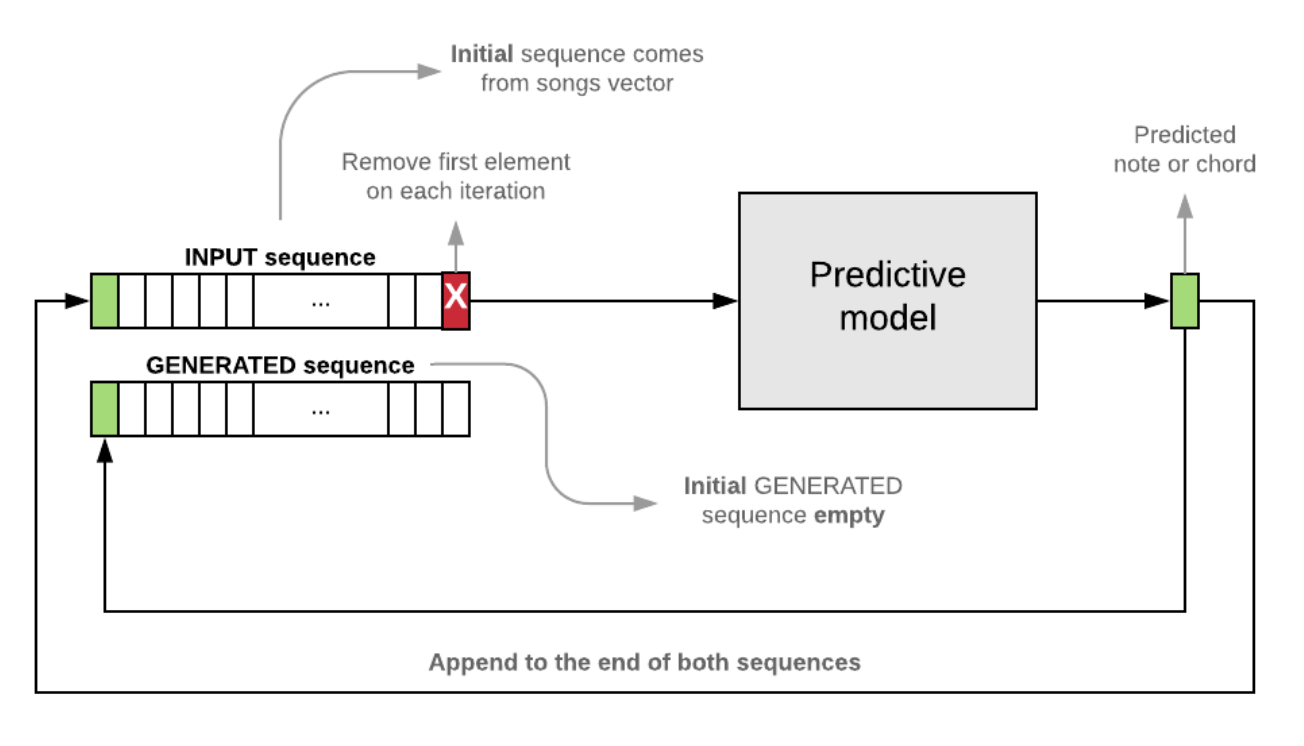

In [0]:
Image('model_generation.PNG', width=800, height=500)

We begin with a full list of note sequences. From the list we choose a random index as a starting point, which allows us to **rerun the generation code without changing anything while at the same time obtaining different results at each run**. 

It's up to the architect to control the starting point. We choose a random beginning. However, by simply replacing the random function with a command line argument, one can appoint the start. 

Once the notes from our training model have been successfully extracted, and the starting point has been randomly selected, a mapping function decodes the output of the network, mapping from numerical data to categorical data, which, in kinder verbiage, means it maps numbers to notes.

We select a count of 500 notes for the model to generate, which translates to something like two minutes of music. Two minutes is gives our network plenty of open-space to write out a melody.

If we want each note to generate properly, we must first submit a sequence to the network. The first sequence we submit is the sequence of notes positioned at the starting index, an index that in our case has been chosen randomly.

Every sequence that follows the first is applied as input, one by one, using the algorithm:

1.   The first note of the input sequence is removed
2.   The output of the previous sequence iteration is inserted at the end of the current input sequence

Nothing terribly difficult. Here's a representation of the algorithm:

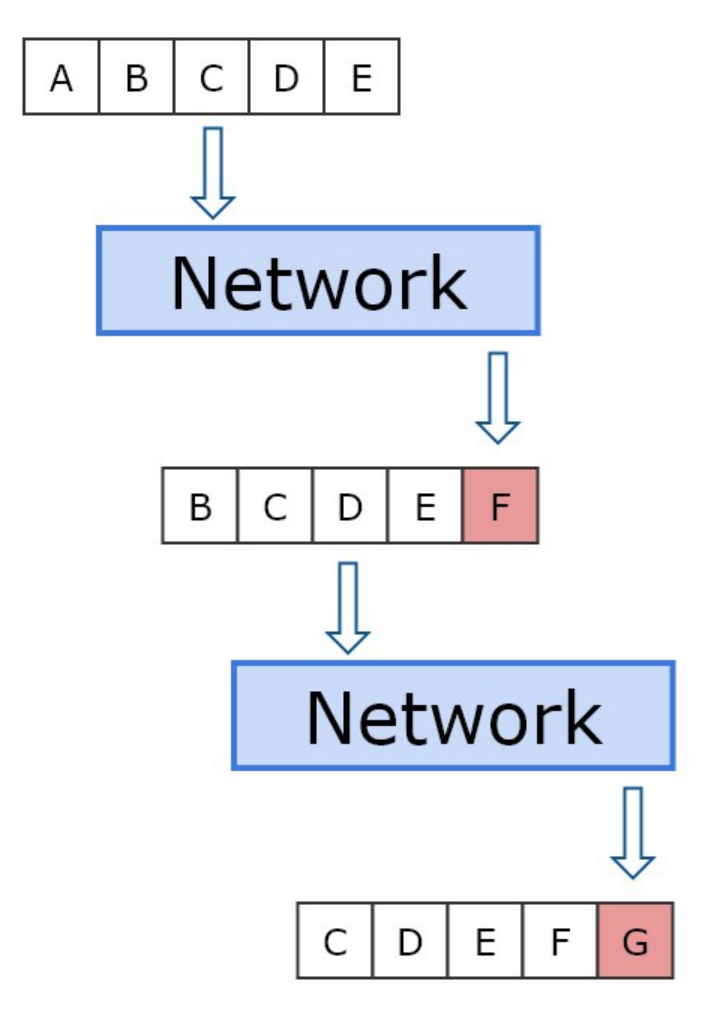

In [0]:
Image('image_sequence_taping.PNG', width=350, height=500)

The first input sequence is *ABCDE*. The output we come by from feeding *ABCDE* is *F*. For the next iteration, we remove *A* from the sequence, and append *F*. Then it's wash, rinse, repeat.

We want to determine the most likely prediction from the output of the network. To do this, we extract the index with the juciest value. The juciest value at index Z in the output array corresponds to the probability that Z is the next note. For instance: 

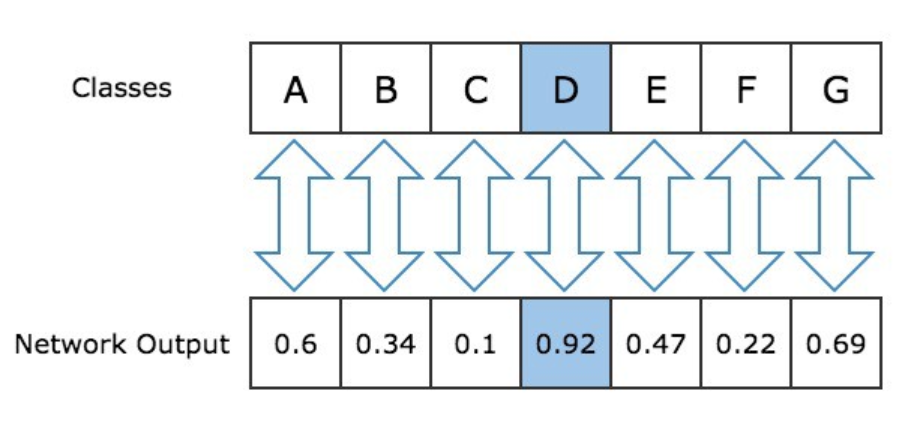

In [0]:
Image('image_prediction_explanation.PNG', width=350, height=200)

From the figure above we see an example of mapping between an output prediction from the network and classes. As we can see, the highest probable value should be *D*. So we choose *D* as the most likely class.

Next, we collect all the outputs from the network into a single array. Having all the encoded representations of the notes and chords in an array now, we can start decoding them to create an array built from *Note* and *Chord* objects.

Before we can build this array, though, we have to determine whether the output we are decoding is a *Note* or a *Chord*. Makes sense.

If the pattern reveals the output as a *Chord*, we then split the chord string into an array of notes, and then loop through the string representation of each note, creating a *Note* object for each. Finally, we knock together a *Chord* object based out of these notes. 

On the other hand, if the pattern is a *Note*, we then create a *Note* object using the string representation of the pitch code contained in the pattern. 

At the completion of each iteration in course, we raise the offset by 0.5, and append the *Note*/*Chord* object we have created onto a list.

Now we have a list of *Notes* and *Chords* generated by the network. Using these, we can create a *music21.stream* object using the list we have molded as a parameter. And finally, we produce the midi file to contain the music generated by the network with *music21.write*, which writes the stream object to a file that we upload into our *Google Drive*, and download onto our desktop for listening.

Here are some metrics our model produced:

## Model I: Testing

---
The testing of the *Model I* architecture practically behaves along the same rules and algorithmic regulations as *Model II*. The trademark difference is in the way each was programmed. 

In [0]:
# def generate():
    """ test / generate a piano midi file """
    # load the notes used to train the model
    with open('data/notes', 'rb') as filepath:
        notes = pickle.load(filepath)

    # obtain all of the pitch names
    pitchnames = sorted(set(item for item in notes))
    # obtain all of the pitch names
    n_vocab = len(set(notes))

#     network_input, normalized_input = prepare_sequences(notes, pitchnames, n_vocab)
#     model = create_network(normalized_input, n_vocab)
#     prediction_output = generate_notes(model, network_input, pitchnames, n_vocab)
#     create_midi(prediction_output)

In [0]:
# def prepare_sequences(notes, pitchnames, n_vocab):
    """ prepare the sequences used by the network """
    # map between notes and integers and back
    note_to_int = dict((note, number) for number, 
                       note in enumerate(pitchnames))

    sequence_length = 100
    network_input = []
    output = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)
    # reshape the input into a format compatible with the LSTM layers
    normalized_input = numpy.reshape(network_input, 
                                    (n_patterns, sequence_length, 1))
  # perform normalization on the input
    normalized_input = normalized_input / float(n_vocab)

#   return (network_input, normalized_input)

## Loading Trained Weights

---

After training, we have a number of weight checkpoint files in our local directory. We've gotten rid of every file but the one with the smallest loss value. The checkpoint with the smallest loss looks something like this:

*weights-improvement-19-1.9435.hdf5*

Once we locate the checkpoint with the smallest loss, we load the network weights, as seen in the overhead cell, from a checkpoint file, and abra-kadabra-alakazam: the network does not need to be trained.

---



In [0]:
# def create_network(network_input, n_vocab):
    model = Sequential()
    model.add(LSTM(
        512,
        input_shape=(network_input.shape[1], 
                     network_input.shape[2]),
                     return_sequences=True
    ))
    model.add(Dropout(0.3))
    model.add(LSTM(512, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(512))
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    # load previously trained weights
    weights = "weights-improvement-19-1.9435.hdf5"
    model.load_weights(weights)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

#     return model

In [0]:
# def generate_notes(model, network_input, pitchnames, n_vocab):
""" Generate notes from the neural network based on a sequence 
    of given notes, and continue on in this 'lookback' method """
    # pick a random sequence from the input as a starting
    # point for the prediction of the first output sequence
    start = numpy.random.randint(0, len(network_input)-1)
    int_to_note = dict((number, note) for number, note 
                        in enumerate(pitchnames))
    
    pattern = network_input[start]
    prediction_output = []

    # generate 500 fresh notes
    for note_index in range(500):
        prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = numpy.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern.append(index)
        pattern = pattern[1:len(pattern)]

#     return prediction_output

In [0]:
# def create_midi(prediction_output):
""" convert the output from the 
    prediction to notes and cre
    ate a midi file from these """
    offset = 0
    output_notes = []
    # create note and chord objects 
    # based on the generated values
    for pattern in prediction_output:
        # if the given pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # if the given pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)
        # increase offset each iteration 
        # preventing against note stacks
        offset += 0.5
    # using a music21 object, write to midi
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='/content/drive/My Drive/train_dir.mid')

## Model II: Testing

---
The testing of the *Model II* architecture practically behaves along the same rules and algorithmic regulations as *Model I*. The trademark difference is in the way each was programmed. 

In [0]:
# make a dictionary it
# erating backwards wi
# th index as a key an
# d note as the value
backward_dict = dict()
for note in note_dict.keys():
    index = note_dict[note]
    backward_dict[index] = note

# pick a random sequence from the input as a 
# jumping-off point for the model prediction
n = np.random.randint(0, len(input_notes)-1)
sequence = input_notes[n]
start_sequence = sequence.reshape(1, sequence_length, vocab_length)

output = []

# range is an arbitrary
# number of notes to pi
# ck from. in a nutshel
# l, its the generation
# length
for i in range(0, 500):
    newNote = model.predict(start_sequence, verbose=0)
    # Get the position with the highest probability
    index = np.argmax(newNote)
    encoded_note = np.zeros((vocab_length))
    encoded_note[index] = 1
    output.append(encoded_note)
    sequence = start_sequence[0][1:]
    start_sequence = np.concatenate((sequence, encoded_note.reshape(1, vocab_length)))
    start_sequence = start_sequence.reshape(1, sequence_length, vocab_length)

In [0]:
finalNotes = [] 
for element in output:
    index = list(element).index(1)
    finalNotes.append(backward_dict[index])
    
offset = 0
output_notes = []
    
for pattern in finalNotes:
    # if pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # if pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)

    # increase offset each iteration so that notes do not stack
    offset += 0.5

midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='/content/drive/My Drive/train_dir.mid')

## What Changed Between Models I & II?

---

Mainly? The programming style. The algorithmic warp and woof of the testing, or, generative process is barebonedly exact from one model to the next. 

Outstanding differences between the two models include *Model I* tailoring a more complex process of generation, whereas *Model II* has greater readability. *Model I* makes use of the *Python Standard Library Data Persistance* module, *pickle*. 

The *pickle* module implements binary protocols for serializing and de-serializing a *Python* object structure, a conversion operation known around the community as *pickling* and *unpickling*.

In the long and short of things, several of the results of our model were all right, and several others were below par, in my opinion. It's incredible that the model can learn to compose melodic phrasings, yet, at the same time, I would've enjoyed to build the architecture more. Below are analytic charts describing the key range and pitch range of one of the testing, generative songs:

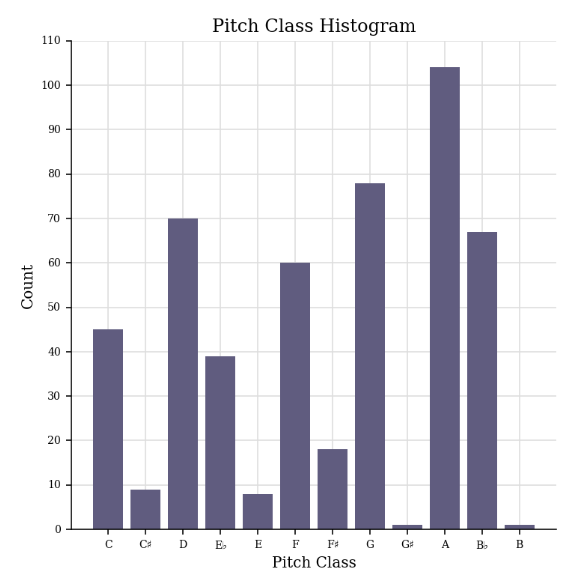

In [0]:
Image('test_output_histogram_pitch.PNG', width=500, height=500)

The figure seen above is a *Pitch Class Histogram* plot from the *music21* library. It displays the count of notes generated by the network. As you can see, note A has the floor by a twenty-note count in this midi generation instance. Note C# and E are barely represented, and notes G# and B are used only once. Lets look at another diagram of the same generative midi instance for more insight into what is going on here: 

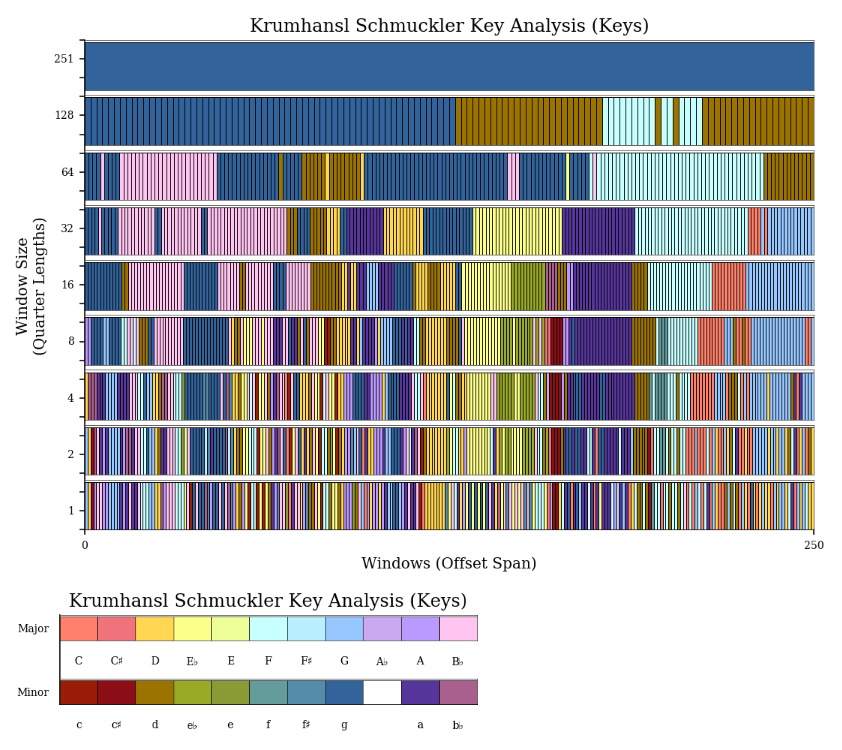

In [0]:
Image('test_key_analysis_20_epochs_amped_100_sequences.PNG', width=700, height=700)

The *Krumhansl Schmuckler Key Analysis* displays which keys, major or minor, were used at what frequency. As we can see from the colors, the model has a pretty decent understanding of key change, an important element in music composition.

# Conclusion

---
I suppose the only information left to give is where to go from here. What I've learned from Deep Learning is that the architecture you use is never fully completed, and always has a broad space open for improvement. 

From here, I plan to fiddle around and see if I can't apply further architecture onto my pre-existing model. Before programming the *LSTM* architecture seen in this analysis, I set the bar high. I tried to work my way into state-of-the-art generative models, such as *Google's* *Transformer* model, the improved *Transformer-XL*, and several brilliant layering techniques including the application of *self-attention*, *multi-head self-attention*, and *relative-attention*, and so on, as well as different framework architectures like the *encoder-decoder* model, and data preprocessing methods that employ music theory as grammars that build the corpus dataset seen in networks like *Ji-Sung Kim's* *DeepJazz*.

The generative capabilities of my model would markedly increase if I employed any one of these methods. What held me back was time. These methods, architectures, and models use complex algorithms to obtain the desired generative results. Understanding complex model architecture takes time. As a full-time student, I'm short on that commodity. 

However, soon as I can find some to spare, I'll use what I learned during this analysis to mature and expand the seed of this model into a full-fledged music generator.

The end.
